# La bibliothèque Quantique

### Résumé

Bob est victime d’un mauvais sort. Vous savez que le rituel pour lever cette malédiction est consigné dans un grimoire qui se trouve dans une bibliothèque quantique. Le problème est que dans une bibliothèque quantique, l’emprunt se fait toujours au hasard. Afin de maximiser vos chances d’emprunter le bon grimoire et ainsi lever le mauvais sort qui afflige Bob, vous utiliserez l’algorithme de Grover, la probabilité d’amplitude et l’interférence. Le bon grimoire sera marqué par Aika, en inversant sa phase quantique.

Trouvez comment lever le mauvais sort.

https://www.youtube.com/watch?v=YFe5MEPo09I

### Etape 1 : création de toutes les possibilités d'Aika pour marquer le bon grimoire (oracles)

Rappel : le premier grimoire correspond au deux qbits 00, le second 01, le 3e 10 puis le dernier 11

In [1]:
# import des libs necessaires
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
import matplotlib
from qiskit import Aer
from qiskit.visualization import plot_state_city

On défini le circuit permettant d'inverser la phase quantique de l'état 00 négative, ce qui permet de marquer le premier grimoire comme le bon quand Aika dit que c'est celui-ci.

Cela permet d'inverser l'amplitude de probabilité du cas 00 et ce sera utile lors de l'utilisation du diffuseur

Pour inverser la phase quantique au cas 00, on applique d'abord un porte NOT sur chacun des qbits, pour passer à 11, cela permet l'activation de la porte Control Z (cz) qui permet d'inverser la phase quantique, puis les qbits sont remis à leur état d'origine

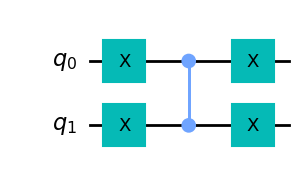

In [2]:
def first_book_circuit():
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.x(1)
    circ.cz(0,1)
    circ.x(0)
    circ.x(1)
    return circ
    
circ = first_book_circuit()
circ.draw(output='mpl')

Nous pouvons ensuite suivre la même logique pour les autres cas 01, 10 et 11 ce qui nous donne les différentes fonctions et circuits

Attention ! on lit les qbits de droite à gauche, dans le second cas 01, q0 = 1 et q1 = 0, dans le troisième cas, q0 = 0 et q1 = 1

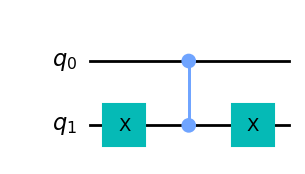

In [3]:
# Cas du 01 (q0=1,q1=0), on met à 1 le q1, on applique cz, puis on remet q1 à 0
def second_book_circuit():
    circ = QuantumCircuit(2)
    circ.x(1)
    circ.cz(0,1)
    circ.x(1)
    return circ
    
circ = second_book_circuit()
circ.draw(output='mpl')

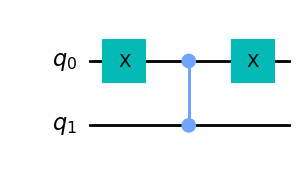

In [4]:
# Cas du 10 (q0=0,q1=1), on met à 1 le q0, on applique cz, puis on remet q0 à 0
def third_book_circuit():
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.cz(0,1)
    circ.x(0)
    return circ
    
circ = third_book_circuit()
circ.draw(output='mpl')

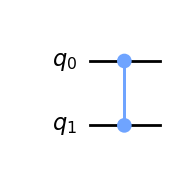

In [5]:
# Cas du 11, Comme tout est à 1, pas besoin de NOT pour l'activation de cz, on applique juste cz
def fourth_book_circuit():
    circ = QuantumCircuit(2)
    circ.cz(0,1)
    return circ
    
circ = fourth_book_circuit()
circ.draw(output='mpl')

## Etape 2 : Le diffuseur

Maintenant que tous les oracles (Aika) sont définis, on peut mettre en place le diffuseur. Effectivement, il est encore trop tot pour pouvoir avoir le bon choix lors de l'utilisation du circuit, puisque même si la phase à changée, sa probabilité n'a pas changée. On utilisera donc le diffuseur pour augmenter l'amplitude de probabilité du bon livre ayant sa phase quantique inversé.

Pour cela, il faut créer un circuit à 2 qbits. On applique une porte H à chaque qbits, car on veut forcer l'etat de superposition, pour que le diffuseur soit applicable sur tous les grimoires à la fois.

En superposition, nos qbits seront donc 0 et 1 à la fois, on pourra donc gérer à la fois 00, 01, 10 et 11. Comme l'oracle sera appliqué avant, la bonne combinaison contiendra une phase négative ce qui permet de ne pas perdre l'information du bon livre à choisir. En appliquant le diffuseur, l'etat inversé (défini par l'oracle) aura une amplitude positive de 1 tandis que les autres auront 0. Quand on applique le diffuseur sur les autres etats qui ne sont pas défassés, leur amplitude sera selement de +/- 0.25. Enfin, l'etat produit sera la somme des 4 états individuels, en sachant que celui défassé aura eu, lors de l'application du diffuseur, une valeur d'amplitude bien plus importe, la somme des applitudes positives et negativ montrera clairement celle de l'etat défasé en grande majorité (elle sera de 1, soit 100 %, dans le cas de 4 grimoires, ou 95% dans le cas de 8 grimoires, ce qui reste une probabilité très suffisante).

Pour revenir au circuit de ce diffuseur, la porte Z ensuite appliquée permet d'inverser les phases des qbits avant d'appliquer la porte CZ qui permet l'amplification, qui crééra ce phénomène d'amplitudes positives et compensées par de nouvelles amplitudes négatives, sauf pour l'etat ciblé qui était ciblé.

Enfin, l'application des 2 portes H permettent de rétablir la superposition permettant de gerer tous les etat et d'appliquer cette somme.



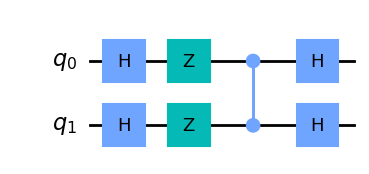

In [6]:
def diffuseur():
    circ = QuantumCircuit(2)
    # portes H comme expliqué ci dessus
    circ.h(0)
    circ.h(1)
    
    # Porte Z pour inverser les phases
    circ.z(0)
    circ.z(1)
    
    # cz pour créer une amplitude négative si ce n'ets pas la bonne solution
    circ.cz(0, 1)
    
    # portes H comme expliqué ci dessus
    circ.h(0)
    circ.h(1)
    return circ
    
circ = diffuseur()
circ.draw(output='mpl')

### Etape 3 : Application et résultats
Finalement, il ne reste plus qu'à tester tous nos oracles et notre diffuseur sur un circuit, qui représente notre question

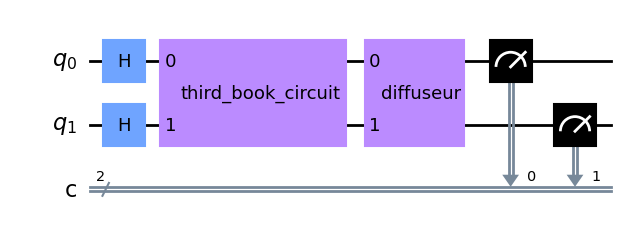

In [7]:
# Cette fonction permet de transformer un circuit en une nouvelle porte quantique personnalisée
def toGate(circuit, name):
    gate = circuit.to_gate()
    gate.name = name # nom affiché lors du rendu
    return gate

# Circuit quantique permettant d'utiliser l'orcle et le diffuseur
def getRightBookAfterAikaAction(aikaOracle):
    circ = QuantumCircuit(2, 2)
    # portes H pour mettre en superposition nos qubits, cela permet de pouvoir gérer les 4 cas 00, 01, 10 et 11
    circ.h(0)
    circ.h(1)
    
    # ajout de l'oracle, le choix d'aika qui determine lequel est le bon livre en inversant sa phase
    circ.append(aikaOracle, [0, 1])
    
    # ajout du diffuseur, permettant de determiné comme expliqué quelle livre il faut choisir
    circ.append(toGate(diffuseur(), "diffuseur"), [0, 1])

    # Ajouter des instructions de mesure de nos qubits
    circ.measure([0, 1], [0, 1])
    return circ

circ = getRightBookAfterAikaAction(toGate(third_book_circuit(), "third_book_circuit"))
circ.draw(output='mpl')


On peut ensuite afficher l'histogramme de notre circuit, une fois la mesure prise. On voit bien que sur 1024 lancé, on obtient 1024 fois la même reponse. Si, comme dans l'example de la vidéo, aika applique le third_book_circuit (donc que le livre dont la phase est inversée est le 3e), alors on arrive bien grâce à notre diffuseur à trouver le bon livre. On peut ainsi soigner Bob.

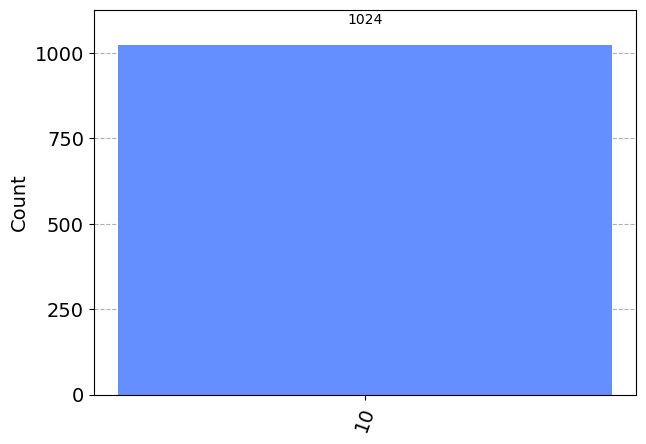

In [8]:
from qiskit.visualization import plot_histogram

def getCounts(circ):
    aer_sim = Aer.get_backend('aer_simulator') # simulateur quantique
    t_qc = transpile(circ, aer_sim)
    return aer_sim.run(t_qc).result().get_counts()
    
# récupère sur nos lancés le nombre de résultat par état, puis l'affiche
counts = getCounts(circ)
plot_histogram(counts)

In [9]:
# Intéprétation textuelle du resultat, on voit qu'on a bien trouvé le bon livre
def showNeededBookFromCounts(counts):
    qbitsResult = list(counts)[0] 

    print('Livre à choisir :')
    if (qbitsResult == "00"):
        print('Livre 1')
    elif (qbitsResult == "01"):
        print('Livre 2')
    elif (qbitsResult == "10"):
        print('Livre 3')
    elif (qbitsResult == "1"):
        print('Livre 4')
showNeededBookFromCounts(counts)

Livre à choisir :
Livre 3


Il est possible de verfier cela avec d'autres choix. On peut essayer dans le cas ou Aika aurait dit que le livre à choisir était le 1er:

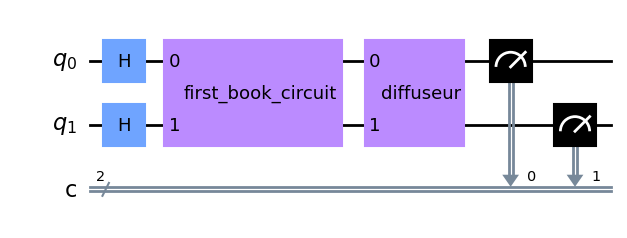

In [10]:
# Affichage du circuit quantique pour le livre 00 livre recherché
circ = getRightBookAfterAikaAction(toGate(first_book_circuit(), "first_book_circuit")) 
circ.draw(output='mpl')

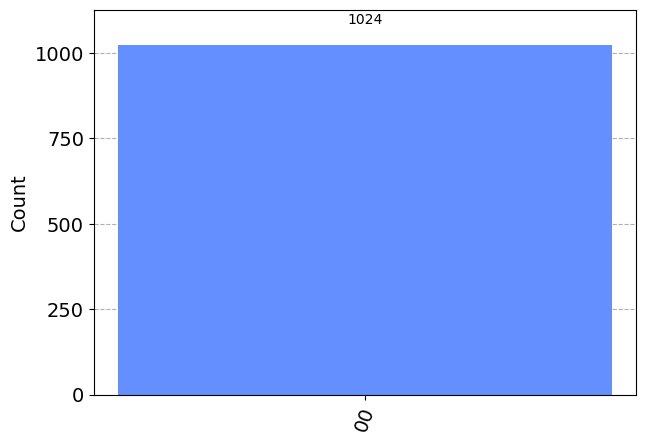

In [11]:
# Affichage du resultat
counts = getCounts(circ)
plot_histogram(counts)

In [12]:
# Interprétation du résultat
showNeededBookFromCounts(counts)

Livre à choisir :
Livre 1
